# Topic model of ACL privacy full docs

In [97]:
from preproc_utils import *
from topic_model_utils import *

In [3]:
# %who shows the namespace

BeautifulSoup	 CoherenceModel	 CountVectorizer	 Dictionary	 HdpModel	 LdaMallet	 LdaModel	 LsiModel	 NamespaceMagics	 
TfidfTransformer	 WordNetLemmatizer	 autopep8	 compute_coherence_lda	 corpora	 datapath	 display_topics	 dump	 format_topics_sentences	 
gensim	 get_ipython	 get_similar_docs_4_new_docs	 get_topics_4_new_docs	 getsizeof	 html5lib	 joblib	 json	 load	 
logging	 nltk	 normalize	 np	 os	 pd	 plt	 pprint	 pyLDAvis	 
random	 re	 read_data_from_url	 requests	 sent_tokenize	 similarities	 simple_preprocess	 sleep	 smart_open	 
sp	 spacy	 stopwords	 summarize	 time	 var_dic_list	 warnings	 word_tokenize	 yapf_reformat	 



In [98]:
# Load data
df = load(
    open(
        "/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_docs.pkl",
        "rb"))
data_words = load(
    open(
        "/Users/dbm/Documents/Insight S19/data/acl_privacy_policy_full_doc_words.pkl",
        "rb"))
print(df.shape, len(data_words))

(1001, 5) 1001


In [5]:
# Split data into words to create a BOW model
split_data_words = [content.split() for content in data_words]

## Train test split

In [99]:
# Split data into training and test sets
train_prop = 0.8
num_train = int(len(data_words)*train_prop)
train_words = split_data_words[:num_train]
test_words = split_data_words[num_train:]
train_df = df.iloc[:num_train,:]
test_df = df.iloc[num_train:,:]
print(f'Num documents in train set: {len(train_words)}; Num documents in test set: {len(test_words)}')
print(f'Num documents in train set: {train_df.shape}\nNum documents in test set: {test_df.shape}')

Num documents in train set: 800; Num documents in test set: 201
Num documents in train set: (800, 5)
Num documents in test set: (201, 5)


In [100]:
train_df.head()

,file,text,type,co_name,word_count_filt
0,/Users/dbm/Downloads/corpus/www_google_co_nz.xml,"When you share information with us, for exampl...",pp,google,763
1,/Users/dbm/Downloads/corpus/ibnlive_in.xml,Web18 recognizes the importance of protecting...,pp,ibnlive,571
2,/Users/dbm/Downloads/corpus/www_gocomics.xml,The privacy policy below details the measures ...,pp,gocomics,1405
3,/Users/dbm/Downloads/corpus/www_petsmart.xml,"By using this Site, you agree to be bound by o...",pp,petsmart,942
4,/Users/dbm/Downloads/corpus/www_duolingo.xml,"By using, accessing or participating in the S...",pp,duolingo,255


## Create BOW

In [101]:
%%time
# Create corpora for topic modeling
# Create dictionary train
id2word = corpora.Dictionary(train_words)

# Filter extremes in dictionary
id2word.filter_extremes(no_below=1, no_above=0.75)

print(f'number of words in dictionary {len(id2word)}')

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in train_words]

# Save corpora and dictionary
dump(corpus, open('acl_policy_corpus_train_fulldoc.pkl', 'wb'))
id2word.save('acl_policy_dictionary_train_fulldoc.gensim')

number of words in dictionary 10882
CPU times: user 731 ms, sys: 21.2 ms, total: 752 ms
Wall time: 757 ms


In [102]:
%%time
# Create dictionary test
id2word_test = corpora.Dictionary(test_words)

# Filter extremes in dictionary
id2word_test.filter_extremes(no_below=1, no_above=0.75)
print(f'number of words in test dictionary {len(id2word_test)}')

# Term Document Frequency
corpus_test = [id2word.doc2bow(text) for text in test_words]

# Save corpora and dictionary
dump(corpus_test, open('acl_policy_corpus_test_fulldoc.pkl', 'wb'))
id2word_test.save('acl_policy_dictionary_test_fulldoc.gensim')

number of words in test dictionary 6050
CPU times: user 356 ms, sys: 7.27 ms, total: 363 ms
Wall time: 364 ms


In [11]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

## LDA model

In [104]:
%%time
# Determine optimum number of topics
# Can take a long time to run
model_list, coherence_values = compute_coherence_lda(
    dictionary=id2word, corpus=corpus, texts=train_words, start=2, limit=20, step=1)

CPU times: user 3min 10s, sys: 3.32 s, total: 3min 14s
Wall time: 1min 44s


Max coherence: 0.2940653768955771, Num Topics at max coherence: 16


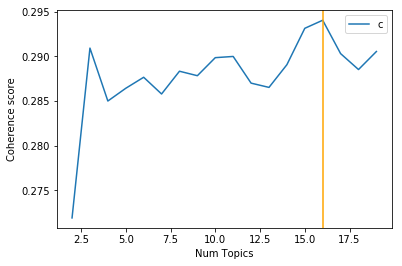

In [105]:
# Show graph
limit = 20
start = 2
step = 1
#  Find the index of the max value
max_idx = coherence_values.index(max(coherence_values))
# Sanity check
# coherence_values[19]
x = range(start, limit, step)
print(f'Max coherence: {max(coherence_values)}, Num Topics at max coherence: {x[max_idx]}')
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=x[max_idx], color = 'orange')
plt.show()

In [ ]:
# Print the coherence scores
# for m, cv in zip(x, coherence_values):
#     print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [106]:
# Select the model and print the topics
optimal_model = model_list[max_idx]
model_topics = optimal_model.show_topics(formatted=False)
# pprint(optimal_model.print_topics(num_words=10))

In [107]:
%%time
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=train_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.618705476753672

Coherence Score:  0.2940653768955771
CPU times: user 7.24 s, sys: 165 ms, total: 7.41 s
Wall time: 5.17 s


In [108]:
# Save model to disk.
temp_file = datapath("./optimal_LDA_model_acl_train_16top_fulldoc")
# temp_file = datapath("./optimal_LDA_model_acl_train_4top_fulldoc")
optimal_model.save(temp_file)

In [58]:
%%time
# Visualize the topics 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 5, sort_topics = True)

CPU times: user 10.2 s, sys: 237 ms, total: 10.5 s
Wall time: 3min 2s


In [59]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.005132  0.003557       1        1  16.466818
8      0.005334  0.000434       2        1  11.927823
12     0.005986  0.002468       3        1  11.170774
11     0.002647 -0.000234       4        1   7.852218
6      0.002141  0.000206       5        1   7.534594
5      0.001504 -0.003669       6        1   6.323716
13     0.005390 -0.001191       7        1   5.774126
14    -0.010736  0.007451       8        1   5.720672
1      0.000054 -0.003933       9        1   5.593760
0     -0.003867 -0.004352      10        1   5.341958
10    -0.000173  0.006089      11        1   5.081438
2     -0.000716  0.002847      12        1   3.443042
4     -0.003859  0.004245      13        1   2.844194
3     -0.005131 -0.008997      14        1   2.182621
7     -0.000116 -0.001211      15        1   1.462905
9     -0.003591 -0.003709      16        1   1.279341, topic_info=      Category         Freq           Term        Total  loglift  logprob
193    Default  3537.000000     personally  3537.000000   5.0000   5.0000
13     Default  2825.000000    advertising  2825.000000   4.0000   4.0000
21     Default  1757.000000    application  1757.000000   3.0000   3.0000
47     Default  1754.000000  communication  1754.000000   2.0000   2.0000
359    Default  2271.000000       customer  2271.000000   1.0000   1.0000
3521    Topic1     1.886235         vistor     2.551775   1.5016 -10.5335
9358    Topic1     1.886235   cryptography     2.551775   1.5016 -10.5335
10819   Topic1     1.846467           sdsu     3.501451   1.1639 -10.5548
10818   Topic1     2.486729       nacelink     4.719395   1.1631 -10.2571
6656    Topic1     1.712755       leadback     3.625365   1.0540 -10.6300
5487    Topic1    42.801147    nickelodeon   115.585983   0.8104  -7.4115
13      Topic1   641.735229    advertising  2825.111328   0.3217  -4.7039
174     Topic1   457.233795         mobile  1964.304199   0.3461  -5.0429
246     Topic1   282.152557         review  1151.597656   0.3974  -5.5256
109     Topic1   469.119781        feature  2173.308105   0.2707  -5.0172
502     Topic1   220.995316     additional   892.694153   0.4077  -5.7699
21      Topic1   371.488495    application  1757.116089   0.2499  -5.2505
34      Topic1   440.195496       business  2261.250732   0.1674  -5.0808
418     Topic1   390.149445      marketing  2052.743164   0.1434  -5.2015
193     Topic1   408.118835     personally  3537.761230  -0.3559  -5.1565
8491    Topic2     2.566835      proposing     3.454209   1.8294  -9.9029
5362    Topic2     2.508028      pageviews     3.437240   1.8111  -9.9261
6043    Topic2     2.418832        likebox     3.439203   1.7743  -9.9623
6173    Topic2     3.254179        apassah     4.689628   1.7609  -9.6656
8489    Topic2     1.347312      consentif     2.118064   1.6739 -10.5475
193     Topic2   601.109070     personally  3537.761230   0.3538  -4.4468
13      Topic2   435.018341    advertising  2825.111328   0.2554  -4.7702
4       Topic2   325.977203       activity  1987.422607   0.3185  -5.0588
109     Topic2   345.683289        feature  2173.308105   0.2878  -5.0001
150     Topic2   311.328979       interest  1973.234985   0.2797  -5.1047
...        ...          ...            ...          ...      ...      ...
4165   Topic15     0.495602      norwegian     4.859468   1.9418  -9.4491
4595   Topic15     6.341969           talk    95.630241   1.5114  -6.8999
6002   Topic15     4.503671       football    78.496201   1.3666  -7.2422
5718   Topic15     1.658202         campus    24.106623   1.5480  -8.2414
528    Topic15    42.880386          child  1995.401733   0.3846  -4.9887
21     Topic15    38.508549    application  1757.116089   0.4042  -5.0963
193    Topic15    60.644497     personally  3537.761230   0.1585  -4.6421
38     Topic15    33.083324           card  1458.937012   0.4383  -5.2481
61     Topic15    30.8547

In [ ]:
# Save lda vis 'acl_optimal_lda_4top_fulldoc.html'
# pyLDAvis.save_html(vis, 'acl_optimal_lda_5top_fulldoc.html')

In [113]:
pyLDAvis.enable_notebook()
vis_tsne = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, R = 10, sort_topics = True, mds = 'tsne')

In [114]:
vis_tsne

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
15    -577.094604  383.420990       1        1  16.533941
8     -438.312103 -491.510254       2        1  11.882208
12     924.638489   44.137722       3        1  11.148903
11     203.735901 -350.342255       4        1   7.943484
6     -142.463669 -174.751770       5        1   7.517119
5     -199.224411  707.705627       6        1   6.248162
14     511.899689 -107.082550       7        1   5.783246
13     573.004822  311.040894       8        1   5.757191
1     -570.494690  -69.538040       9        1   5.596101
0      162.250748  497.871490      10        1   5.336561
10     396.500732 -736.602173      11        1   5.169855
2      514.342468  738.479004      12        1   3.406479
4      -60.119793 -696.490540      13        1   2.833380
3      749.943604 -446.564514      14        1   2.152336
7      182.913406   89.008476      15        1   1.458972
9     -181.773575  232.769836      16        1   1.232059, topic_info=      Category         Freq            Term        Total  loglift  logprob
193    Default  3535.000000      personally  3535.000000  10.0000  10.0000
13     Default  2827.000000     advertising  2827.000000   9.0000   9.0000
21     Default  1756.000000     application  1756.000000   8.0000   8.0000
47     Default  1754.000000   communication  1754.000000   7.0000   7.0000
359    Default  2273.000000        customer  2273.000000   6.0000   6.0000
528    Default  1993.000000           child  1993.000000   5.0000   5.0000
174    Default  1966.000000          mobile  1966.000000   4.0000   4.0000
418    Default  2052.000000       marketing  2052.000000   3.0000   3.0000
182    Default  1939.000000           offer  1939.000000   2.0000   2.0000
70     Default  1628.000000          credit  1628.000000   1.0000   1.0000
3521    Topic1     1.893924          vistor     2.558632   1.4989 -10.5335
9358    Topic1     1.893924    cryptography     2.558632   1.4989 -10.5335
10819   Topic1     1.853994            sdsu     3.507426   1.1622 -10.5548
10818   Topic1     2.496866        nacelink     4.727489   1.1614 -10.2571
6656    Topic1     1.719737        leadback     3.626362   1.0537 -10.6300
6654    Topic1     1.677453         impress     3.593550   1.0379 -10.6548
4777    Topic1     1.069576           bskyb     2.314565   1.0278 -11.1049
10648   Topic1     1.021903    editoronline     2.218585   1.0246 -11.1505
6660    Topic1     1.641695  rubiconproject     3.572617   1.0222 -10.6764
6659    Topic1     1.648359         rubicon     3.594327   1.0202 -10.6723
10512   Topic1     6.750194            bean    15.982479   0.9378  -9.2626
3336    Topic1    10.728076        comscore    26.135921   0.9093  -8.7993
5487    Topic1    42.975616     nickelodeon   115.694664   0.8094  -7.4115
9206    Topic1     3.171419        starfall     7.361276   0.9577 -10.0179
7991    Topic1     5.230990          kijiji    12.833686   0.9023  -9.5175
13      Topic1   644.351074     advertising  2827.353027   0.3209  -4.7039
174     Topic1   459.097595          mobile  1966.605347   0.3450  -5.0429
246     Topic1   283.302673          review  1152.213501   0.3968  -5.5256
502     Topic1   221.896149      additional   893.061279   0.4073  -5.7699
109     Topic1   471.032043         feature  2173.295410   0.2707  -5.0172
...        ...          ...             ...          ...      ...      ...
7183   Topic16     0.269109    addressemail     3.501898   1.8305  -9.8880
7191   Topic16     0.810517        staffing    10.619036   1.8238  -8.7855
7182   Topic16     0.269423   addresscredit     3.550323   1.8180  -9.8869
8155   Topic16     0.232836        southern     3.141864   1.7942 -10.0328
2270   Topic16     0.858071        caremark    11.987742   1.7595  -8.7285
7186   Topic16     0.248885        diabetic     3.577630   1.7310  -9.9662
10436  Topic16     0.188181          winter     2.731468   1.72

In [115]:
# Save lda vis 'acl_optimal_lda_4top_fulldoc.html'
pyLDAvis.save_html(vis_tsne, 'acl_optimal_lda_16top_fulldoc_tsne.html')

In [116]:
# Find the dominant topic for each document
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=train_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.8741,"cookie, personally, type, technology, activity...","[share, creating, relevant, search, connect, p..."
1,1,8.0,0.6460,"personally, advertising, feature, cookie, acti...","[recognizes, protecting, entrust, safely, secu..."
2,2,12.0,0.8470,"cookie, personally, type, technology, activity...","[detail, measure, protect, connection, upuzzle..."


In [117]:
optimal_model.show_topics(formatted=True, num_words=10)

[(9,
  '0.011*"personally" + 0.007*"advertising" + 0.006*"application" + 0.005*"marketing" + 0.005*"message" + 0.005*"offer" + 0.005*"include" + 0.005*"communication" + 0.005*"public" + 0.004*"child"'),
 (3,
  '0.015*"personally" + 0.006*"mobile" + 0.006*"visitor" + 0.005*"message" + 0.005*"marketing" + 0.005*"feature" + 0.005*"business" + 0.005*"preference" + 0.005*"offer" + 0.005*"credit"'),
 (14,
  '0.012*"customer" + 0.007*"credit" + 0.007*"personally" + 0.006*"communication" + 0.005*"consent" + 0.005*"mobile" + 0.005*"offer" + 0.005*"business" + 0.005*"marketing" + 0.005*"advertising"'),
 (7,
  '0.010*"personally" + 0.007*"child" + 0.006*"application" + 0.006*"advertising" + 0.006*"mobile" + 0.006*"feature" + 0.005*"communication" + 0.005*"interest" + 0.005*"card" + 0.005*"technology"'),
 (4,
  '0.007*"communication" + 0.007*"advertising" + 0.006*"business" + 0.006*"notice" + 0.005*"consent" + 0.005*"partner" + 0.005*"child" + 0.005*"marketing" + 0.005*"offer" + 0.005*"customer"')

In [118]:
# Merge topic info with main df
train_df = train_df.reset_index(drop=True)
train_df_with_topic = pd.concat([train_df, df_dominant_topic], axis = 1)
# print(train_df_with_topic.isna().sum())
train_df_with_topic.head(2)
train_df_with_topic.shape

file                  0
text                  0
type                  0
co_name               0
word_count_filt       0
Document_No           0
Dominant_Topic        0
Topic_Perc_Contrib    0
Keywords              0
Text                  0
dtype: int64


(800, 10)

## Apply topic model to new documents

In [119]:
%%time
# get topic probability distribution for new documents and keywords
new_doc_topic =[]
new_doc_topic_kwords =[]
for i,doc in enumerate(test_words):
    new_doc_bow = id2word.doc2bow(doc)
    try:
        vector = optimal_model[new_doc_bow]#optimal_model.get_document_topics(new_doc_bow) <-- does the same thing
        new_doc_topic.append(vector) 
        new_doc_topic_kwords.append(get_topics_4_new_docs(model = optimal_model, topics= vector, prob = 0.3))        

    except:
        vector = ''
        new_doc_topic.append([i,''])
        new_doc_topic_kwords.append([i, ''])

CPU times: user 1.26 s, sys: 24.4 ms, total: 1.29 s
Wall time: 354 ms


In [120]:
# Find the dominant topic for each document
df_topic_sents_keywords_test = format_topics_sentences(
    ldamodel=optimal_model, corpus=corpus, texts=test_words)

# Format
df_dominant_topic_test = df_topic_sents_keywords_test.reset_index()
df_dominant_topic_test.columns = [
    'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [121]:
df_dominant_topic_test.head(4)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,12.0,0.8478,"cookie, personally, type, technology, activity...","[voluntarily, website, email, address, phone, ..."
1,1,8.0,0.5837,"personally, advertising, feature, cookie, acti...","[describes, registered, office, collect, share..."
2,2,12.0,0.8459,"cookie, personally, type, technology, activity...","[committed, maintaining, confidence, trust, re..."
3,3,4.0,0.6099,"communication, advertising, business, notice, ...","[goal, family, experience, inform, entertain, ..."


In [122]:
df_dominant_topic_test = df_dominant_topic_test.dropna(axis = 0)
df_dominant_topic_test.tail(4)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
197,197,8.0,0.7274,"personally, advertising, feature, cookie, acti...","[requiring, register, section, feature, turn, ..."
198,198,1.0,0.9914,"personally, activity, marketing, cookie, appli...","[hrsdc, responsible, accuracy, reliability, cu..."
199,199,12.0,0.6877,"cookie, personally, type, technology, activity...","[read, understand, practice, notice, discloses..."
200,200,11.0,0.9842,"personally, advertising, advertisement, busine...","[committed, protecting, visitor, summarizes, g..."


In [123]:
# Merge in test_df with topic info
test_df = test_df.reset_index(drop=True)
test_df_with_topic = pd.concat([test_df, df_dominant_topic_test], axis = 1)
print(test_df_with_topic.isna().sum())

file                  0
text                  0
type                  0
co_name               0
word_count_filt       0
Document_No           0
Dominant_Topic        0
Topic_Perc_Contrib    0
Keywords              0
Text                  0
dtype: int64


In [124]:
test_df_with_topic.head(2)

,file,text,type,co_name,word_count_filt,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,/Users/dbm/Downloads/corpus/www_yale_edu.xml,Any information you voluntarily provide to us ...,pp,yale,208,0,12.0,0.8478,"cookie, personally, type, technology, activity...","[voluntarily, website, email, address, phone, ..."
1,/Users/dbm/Downloads/corpus/pages_ebay_com_au.xml,This Privacy Policy describes how eBay Intern...,pp,pages,1216,1,8.0,0.5837,"personally, advertising, feature, cookie, acti...","[describes, registered, office, collect, share..."


## Update topic model

In [125]:
# Update model with the test corpus
optimal_model.update(corpus_test)

In [126]:
%%time
# Compute Perplexity
# Expect perplexity to decrease and coherence to increase
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=test_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.572384633536912

Coherence Score:  0.3128095658915186
CPU times: user 7.13 s, sys: 164 ms, total: 7.29 s
Wall time: 3.41 s


In [127]:
# Save model to disk.
temp_file2 = datapath("./optimal_LDA_model_acl_train_16top_fulldoc_updated")
optimal_model.save(temp_file2)

## Update model with single document

In [128]:
url = 'https://www.manulife.com/en/privacy-policy/privacy-statement.html'
new_doc = read_data_from_url(link = url)#'https://www.dtelepathy.com/blog/inspiration/14-beautiful-content-heavy-websites-for-inspiration')
new_doc = tokenize(pd.Series(new_doc), stop_words=stop_words, frequent_words=frequent_words)
print(f'After text cleaning, there are {len(new_doc[0])} words in the document')
new_doc= sum(new_doc,[])

There are 1010 words in this document.
After text cleaning, there are 360 words in the document


In [129]:
new_doc_bow = id2word.doc2bow(new_doc)
new_doc_top_prob_dist = optimal_model[new_doc_bow]
# Sort topic probability distribution for new document
new_doc_top_prob_dist_df = pd.DataFrame([{'topic': i[0],'prob': i[1]} for i in new_doc_top_prob_dist]).sort_values(
    by=['prob'], ascending=False)
new_doc_top_prob_dist_df = new_doc_top_prob_dist_df.reset_index()
new_doc_top_kwords = get_topics_4_new_docs(
    model=optimal_model, topics=new_doc_top_prob_dist, prob=.25)
new_doc_top_kwords



[[13,
  [('personally', 0.0077192835),
   ('visitor', 0.007641223),
   ('interest', 0.0064853034),
   ('cookie', 0.006427185),
   ('advertising', 0.005789318),
   ('offer', 0.0056759478),
   ('marketing', 0.005581573),
   ('advertisement', 0.005378576),
   ('application', 0.005311424),
   ('customer', 0.005205098)]],
 [12,
  [('cookie', 0.007437635),
   ('type', 0.0067939777),
   ('personally', 0.006379262),
   ('offer', 0.0062742326),
   ('advertiser', 0.0062464504),
   ('partner', 0.0054835235),
   ('activity', 0.0054681464),
   ('advertising', 0.0051522604),
   ('business', 0.005140035),
   ('consent', 0.0051397383)]]]

In [ ]:
%%time
# Update model and examine metrics
# optimal_model.update(new_doc_bow)
# temp_file2 = datapath("./optimal_LDA_model_acl_train_16top_fulldoc_updated")
# optimal_model.save(temp_file2)
# Compute Perplexity
# Expect perplexity to decrease and coherence to increase
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=test_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [77]:
# Get similarities among topics in the corpus
lda_index = similarities.MatrixSimilarity(optimal_model[corpus])

In [130]:
%%time
# Find documents similar to new document
# Let's perform some queries
similarities_1 = lda_index[optimal_model[new_doc_bow]]

# print(similarities_1.shape)
# Sort the similarities
similarities_1 = sorted(enumerate(similarities_1), key=lambda item: -item[1])
 
# Top most similar documents:
# print(similarities_1[:10])
 
# Let's see what's the most similar document
document_id, similarity_1 = similarities_1[0]

similar_docs = get_similar_docs_4_new_docs(similarities_val = similarities_1, similarity_threshold  = 0.87)
similar_docs
print(similar_docs)
# Print a similar document
# print(train_df_with_topic['text'][similar_docs[0]])

[467, 347, 384, 570, 107, 266, 199]
CPU times: user 5.36 ms, sys: 993 µs, total: 6.35 ms
Wall time: 5.4 ms


## Summarize by topic

In [265]:
# train_df_with_topic[train_df_with_topic['Dominant_Topic'] == 3]

In [272]:
#Get the top n documents for each topic
df_topic_gr = train_df_with_topic.groupby('Dominant_Topic')
# for group, _df in df_topic_gr: 
tmp = df_topic_gr.get_group(3)
tmp = tmp.reset_index(drop = True)
tmp = ' '.join(tmp['text'])
tmp = sent_tokenize(re.sub('[^a-zA-Z .!?]+' , '', tmp))
tmp = [i.split('\n') for i in tmp]
tmp = '.'.join(sum(tmp,[]))
tmp = re.sub('[.]{2,}','. ', tmp)
# print(tmp)
summarize(tmp, ratio = .002)
# df_topic_gr.get_group(7)

'We also may share your information with cosponsors of such promotion.To offer you products from our affiliates strategic partners agents or from thirdparty marketers and other unaffiliated parties that we believe may be of interest to you or to assist such parties for research administrative andor business purposes.These parties may contact you with an offer or advertisement related to a product or service or they may use such information for their own research administration or business purposes.To unaffiliated thirdparty service providers agents or independent contractors who help us maintain our websites and us with other administrative services including but not limited to order processing and fulfillment providing customer service maintaining and analyzing data sending customer communications on our behalf and entry collection winner selection and prize fulfillment for contests sweepstakes and other promotions.We seek to ensure that such unaffiliated thirdparties will not use you

In [255]:
# train_df_with_topic[train_df_with_topic['Dominant_Topic'] == 4]

In [163]:
for doc in tmp['text']:
    summary =[]
    tmp = sent_tokenize(doc)
    tmp_clean = [i.split('\n\n') for i in tmp]
    text_pp = ' '.join(sum(tmp_clean,[]))
    try:
        summary.append(summarize(text_pp, ratio = return_prop))   
    except:
        summary = text_pp
#         summary_stories.append({'Dominant Topic':group, 'Summary':summary})
    summary_stories = {'Dominant Topic':group, 'Summary':' '.join(summary)}


In [187]:
doc = ' '.join(tmp['text'].tolist())#tmp['text'][0]
tmp1 = sent_tokenize(re.sub('[^a-zA-Z .!?]+' , '', doc))
tmp_clean = [i.split('\n') for i in tmp1]
text_pp = ' '.join(sum(tmp_clean,[]))
text_pp = re.sub('[.]{2,}','.', text_pp)
summarize(text_pp, ratio = 0.001)

'The types of Personal Information that we collect may includeYour nameYour photographic identification including a high quality image of your government issued ID passport national ID card and EU driving licenceYour addressYour email addressYour banking details including account numbersYour date of birthYour trades andYour utility bill or bank statement confirming your residential address.We may use your Personal Information for the following purposesTo personalize your experience your information helps us to better respond to your individual needsTo improve our website we continually strive to improve our website offerings based on the information and feedback we receive from youTo analyze use of our SiteTo improve customer service your information helps us to more effectively respond to your customer service requests and support needsTo undertake a verification or your identity with our third party electronic identification provider as per the Money Laundering Regulations  and AML p

In [161]:
from gensim.summarization.textcleaner import clean_text_by_sentences, get_sentences 
# get_sentences(tmp)

# summarize(' '.join(sent_tokenize(re.sub('[^a-zA-Z .!?]+' , '',tmp))), ratio = 0.001)
# for sentence in get_sentences(tmp):
#     print(summarize(sent_tokenize(re.sub('[^a-zA-Z .!?]+' , '', sentence))), ratio = 0.05)
# summarize(tmp, ratio = .05) 

'The types of Personal Information that we collect may includeYour nameYour photographic identification including a high quality image of your government issued ID passport national ID card and EU driving licenceYour addressYour email addressYour banking details including account numbersYour date of birthYour trades andYour utility bill or bank statement confirming your residential address.We may use your Personal Information for the following purposesTo personalize your experience your information helps us to better respond to your individual needsTo improve our website we continually strive to improve our website offerings based on the information and feedback we receive from youTo analyze use of our SiteTo improve customer service your information helps us to more effectively respond to your customer service requests and support needsTo undertake a verification or your identity with our third party electronic identification provider as per the Money Laundering Regulations  and AML p

In [292]:
%%time
# Get summary by topic
df_topic_gr = train_df_with_topic.groupby('Dominant_Topic')
return_prop = 0.002
topic_summary = []
for group, _df in df_topic_gr: 
    print(set(_df['Dominant_Topic']))
    first_line = _df['text'].apply(lambda x: sent_tokenize(x)[0])
    tmp = _df.reset_index(drop = True)
    tmp = ' '.join(tmp['text'])
    tmp = sent_tokenize(re.sub('[^a-zA-Z .!?]+' , '', tmp))
    tmp = [i.split('\n') for i in tmp]
    tmp = '.'.join(sum(tmp,[]))
    tmp = re.sub('[.]{2,}','. ', tmp)
    # print(tmp)
    summary = summarize(tmp, ratio = return_prop)
    topic_summary.append({'Dominant_Topic':list(set(_df['Dominant_Topic']))[0], 'summary': summary,'first_line':' '.join(first_line)})    

{0.0}
{1.0}
{2.0}
{3.0}
{4.0}
{5.0}
{6.0}
{7.0}
{8.0}
{9.0}
{10.0}
{11.0}
{12.0}
{13.0}
{14.0}
{15.0}
CPU times: user 2h 34min 50s, sys: 4min 41s, total: 2h 39min 32s
Wall time: 2h 44min 13s


In [295]:
topic_summary_df = pd.DataFrame(topic_summary)
# topic_summary_df.tail(2)
dump(topic_summary, open("/Users/dbm/Documents/Insight S19/data/privacy_optout_topic_level_summary_df.pkl", "wb"))

In [296]:
topic_summary_df['summary'][0]

'For details of how BBC Worldwide uses personal information collected via its other international and UK services please see BBC Worldwides Privacy Policy If you any questions or comments about this Privacy Policy please contactThe Data Protection OfficerRoom White City Building Wood LaneLondonW TSEmail dpa.officerbbc.co.ukIf you are viewing the international version of this website bbc.com and you have any questions or comments about the Privacy Policy please contact BBC Worldwide via email dataprotectionbbc.comLast updated May   As used herein Bitstamp refers to the company Bitstamp Limited including without limitation thereby its owners directors investors employees or other related parties.\nThe types of Personal Information that we collect may includeYour nameYour photographic identification including a high quality image of your government issued ID passport national ID card and EU driving licenceYour addressYour email addressYour banking details including account numbersYour dat

In [194]:
len(topic_summary)
# Save dataset
dump(topic_summary, open("/Users/dbm/Documents/Insight S19/data/privacy_optout_topic_level_summary.pkl", "wb"))


None


In [198]:
sent_tokenize(topic_summary[0]['summary'])[0]

'The types of Personal Information that we collect may includeYour nameYour photographic identification including a high quality image of your government issued ID passport national ID card and EU driving licenceYour addressYour email addressYour banking details including account numbersYour date of birthYour trades andYour utility bill or bank statement confirming your residential address.We may use your Personal Information for the following purposesTo personalize your experience your information helps us to better respond to your individual needsTo improve our website we continually strive to improve our website offerings based on the information and feedback we receive from youTo analyze use of our SiteTo improve customer service your information helps us to more effectively respond to your customer service requests and support needsTo undertake a verification or your identity with our third party electronic identification provider as per the Money Laundering Regulations  and AML p

In [94]:
summary_stories = {}
return_prop = 0.05
for group, _df in df_topic_gr:  
#     display(' '.join(_df['story']))
    for doc in _df['text']:
        tmp = sent_tokenize(doc)
        tmp_clean = [i.split('\n\n') for i in tmp]
        text_pp = ' '.join(sum(tmp_clean,[]))
        try:
            summary=summarize(text_pp, ratio = return_prop)   
        except:
            summary = text_pp
#         summary_stories.append({'Dominant Topic':group, 'Summary':summary})
        summary_stories = {'Dominant Topic':group, 'Summary':' '.join(summary)}

# df_with_topic = dfs.join(df.set_index('Document_No'), on='Document_No')
# df_with_topic.head(5)

In [ ]:
for group, _df in df_topic_gr:  
#     display(' '.join(_df['story']))
    for doc in _df['text']:
        tmp = sent_tokenize(doc)
        tmp_clean = [i.split('\n\n') for i in tmp]
        text_pp = ' '.join(sum(tmp_clean,[]))
        try:
            summary = summarize(text_pp, ratio = return_prop)   
        except:
            summary = text_pp
#         summary_stories.append({'Dominant Topic':group, 'Summary':summary})
        summary_stories = {'Dominant Topic':group, 'Summary':summary}


In [ ]:
tmp = df_topic_gr.get_group(1)

In [ ]:
tmp = sent_tokenize(test_df_with_topic['text'][0])
tmp_clean = [i.split('\n\n') for i in tmp]
text_pp = ' '.join(sum(tmp_clean,[]))
summarize(text_pp, ratio  = 0.05)

### References
- https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#topic=0&lambda=1&term=
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/